# Entropy Analysis + permutations
### 10/20/20; 12/9/20
### Comparing entropy across the different priming groups

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
import random
from sklearn.metrics import jaccard_score
from scipy.stats import entropy
%autosave 5

Autosaving every 5 seconds


# I. Setup
### i. Import data

In [3]:
filename = '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/analysis/segment/usable_data'
data_dict = pickle.load( open( filename, "rb" ) )
filename_sums = '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/analysis/segment/sums_usable_data'
sums = pickle.load( open( filename_sums, "rb" ) )
len(data_dict)

311

### ii. import and organize story files
#### a. Import file

In [4]:
directory_stories = '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/1:8:2020_edited_stories'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

#### b. organize putative event boundaries

In [5]:
#mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = int(dfs_stories[s]['story'].iloc[0])
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries[this_story] = keys2[:, np.newaxis]
    story_boundaries[this_story] = np.concatenate((story_boundaries[this_story], keys3[:, np.newaxis]), axis = 1)
    
#mark the changes or boundaries from one event to another with a '1' and delete first two columns
for key in story_boundaries:
    location = story_boundaries[key][:,0]
    social = story_boundaries[key][:,1]
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            location[i] = 7
    for i in range(0, len(location)):  
        if location[i] != 7:
            location[i] = 0
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            social[i] = 7
    for i in range(0, len(social)):
        if social[i] != 7:
            social[i] = 0
    location[0] = 7
    social[0] = 7
    location2 = location > 1
    social2 = social > 1
    location2 = location2.astype(int)
    social2 = social2.astype(int)
    story_boundaries[key] = np.concatenate((story_boundaries[key], location2[:, np.newaxis]), axis = 1) 
    story_boundaries[key] = np.concatenate((story_boundaries[key], social2[:, np.newaxis]), axis = 1)
    story_boundaries[key] = np.delete(story_boundaries[key] ,np.s_[0:2],axis=1)

# II. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [6]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

<ipython-input-6-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-6-2bd4433a67cf>:26: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-6-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-6-2bd4433a67cf>:26: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-6-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecate

### i. Finding the number of participants in each category for each story
#### -output sums[story] = [total # of participants, no prime, loc primed, soc primed]

In [7]:
sums = {}

for key in all_keys_r:
    this_sum = []
    x, y = all_keys_r[key].shape
    this_sum.append(y)
    if key in none_keys_r:
        x, y = none_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in loc_keys_r:
        x, y = loc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in soc_keys_r:
        x, y = soc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    sums[key] = this_sum

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [8]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

## C. Remove first sentence (first row) from all keypresses

In [9]:
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

## D. Remove first sentence (first row) from all a priori story boundaries

In [10]:
for key in story_boundaries:
    story_boundaries[key] = np.delete(story_boundaries[key],(0), axis = 0)

# III. Entropy analysis
## A. Entropy over all keypresses aggregated together

In [11]:
# Instantiating new dict and iterating through all_keys summing along row-wise
sum_keys = {}

for key in all_keys:
    these_keys = all_keys[key]
    sum_keys[key] = np.sum(these_keys, axis = 1)

###    
#ent[key] = entropy(sum_keys[key])/ln(N[key])    
    
# Plot each sum_keys array with loc boundaries
ent = {}
for key in sum_keys:
    # entropy normalizes the vector
    ent[key] = entropy(sum_keys[key])/np.log(len(story_boundaries[key]))
    
print(ent)

{44: 0.8159781969806121, 11: 0.9077342040404199, 21: 0.8941307316159829, 12: 0.8607126009874999, 23: 0.9105331799779428, 33: 0.917333367741546, 13: 0.8284556396464646, 42: 0.8823387164063776, 34: 0.7990284869087744, 32: 0.9034775296578292, 43: 0.8614615978841627, 41: 0.8703344190335645, 22: 0.8796690973670485, 24: 0.9155480415621586, 14: 0.8406873843415301, 31: 0.7365135600113529}


## B. Entropy over different priming groups

In [12]:
# dicts for summing row-wise
sum_keys_np = {}
sum_keys_l = {}
sum_keys_s = {}

# Instantiating new dicts for ent
ent_np = {}
ent_l = {}
ent_s = {}

list_keys = [none_keys, loc_keys, soc_keys]
list_sums = [sum_keys_np, sum_keys_l, sum_keys_s]
list_ent = [ent_np, ent_l, ent_s]

for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        these_keys = list_keys[i][key]
        list_sums[i][key] = np.sum(these_keys, axis = 1)


for i in range(0, len(list_keys)):
    print(i)
    for key in list_keys[i]:
        list_ent[i][key] = entropy(list_sums[i][key])/np.log(len(story_boundaries[key]))

0
1
2


## C. Averaging across all stories

In [13]:
story_list = [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]

# Initiating array for storing value for each story
np_vals = np.zeros((16))
l_vals = np.zeros((16))
s_vals = np.zeros((16))
count = 0

for j in story_list:
    np_vals[count] = ent_np[j]
    l_vals[count] = ent_l[j]
    s_vals[count] = ent_s[j]
    count += 1
    
avg_np = np.mean(np_vals)
avg_l = np.mean(l_vals)
avg_s = np.mean(s_vals)
print("The avg entropy for np primed participants is ", avg_np)
print("The avg entropy for loc primed participants is ", avg_l)
print("The avg entropy for soc primed participants is ", avg_s)

The avg entropy for np primed participants is  0.807467752981002
The avg entropy for loc primed participants is  0.7957650870113877
The avg entropy for soc primed participants is  0.8127695313553931


# II. Permutation Testing
## A. Shuffle the participants in each story and recalculate the avg entropies for np, loc and soc primed participants

In [14]:
N_perms = 1000
count = 0
none_total = []
loc_total = []
soc_total = []

for i in range(0, N_perms):
    
    # Create array to hold entropy values of each story for each priming group
    t_none_ent = np.zeros((16,1))
    t_loc_ent = np.zeros((16,1))
    t_soc_ent = np.zeros((16,1))
    
    count = 0
    # Shuffle participants in each story
    for key in all_keys:
        # Make a copy of all_keys[key]
        these_keys = np.copy(all_keys[key])
        # Generate a permutation
        randperm = np.random.permutation(sums[key][0])
        # Shuffle columns of the copy
        shuffled = these_keys[:, randperm]
        # Make new keys using the sums from the original data
        new_none_keys = shuffled[:, 0:sums[key][1]]
        new_loc_keys = shuffled[:, sums[key][1]: (sums[key][1]+ sums[key][2])]
        new_soc_keys = shuffled[:, (sums[key][1]+ sums[key][2]): (sums[key][1]+ sums[key][2] + sums[key][3])]
        # Make the new sums
        new_none_sum = np.sum(new_none_keys, axis = 1)
        new_loc_sum = np.sum(new_loc_keys, axis = 1)
        new_soc_sum = np.sum(new_soc_keys, axis = 1)
        # Make the new ent vals
        t_none_ent[count] = entropy(new_none_sum)/np.log(len(story_boundaries[key]))
        t_loc_ent[count] = entropy(new_loc_sum)/np.log(len(story_boundaries[key]))
        t_soc_ent[count] = entropy(new_soc_sum)/np.log(len(story_boundaries[key]))
        count += 1
        
    # Avg the entropy values for each group
    none_total.append(np.mean(t_none_ent))
    loc_total.append(np.mean(t_loc_ent))
    soc_total.append(np.mean(t_soc_ent))
        
        

## B. Print and plot P values

The p value for no prime entropy is  0.489
The p value for loc prime entropy is is  0.13
The p value for soc prime entropy is is  0.753


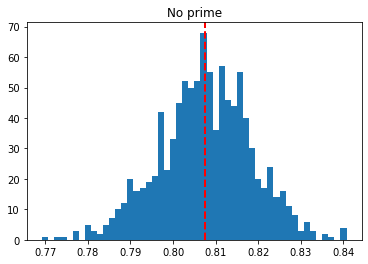

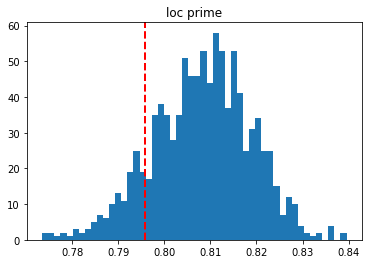

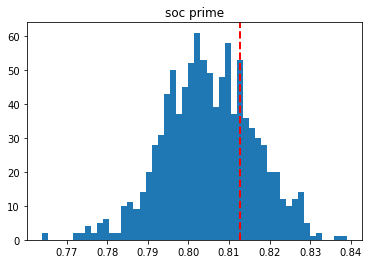

In [15]:
# convert list of PEs to np
PEs = np.asarray(none_total)
# Plot the histogram
plt.hist(PEs, bins = 50)
# Show the actual data
plt.axvline(x=avg_np, color='r', linestyle='dashed', linewidth=2)
# Title
plt.title('No prime')
# Calculate the P-value
p_val = ((PEs < avg_np).sum())/N_perms
print('The p value for no prime entropy is ', p_val)


#Loc

plt.figure()
# convert list of PEs to np
PEs = np.asarray(loc_total)
# Plot the histogram
plt.hist(PEs, bins = 50)
# Show the actual data
plt.axvline(x=avg_l, color='r', linestyle='dashed', linewidth=2)
# Title
plt.title('loc prime')
# Calculate the P-value
p_val = ((PEs < avg_l).sum())/N_perms
print('The p value for loc prime entropy is is ', p_val)

#Soc

plt.figure()
# convert list of PEs to np
PEs = np.asarray(soc_total)
# Plot the histogram
plt.hist(PEs, bins = 50)
# Show the actual data
plt.axvline(x=avg_s, color='r', linestyle='dashed', linewidth=2)
# Title
plt.title('soc prime')
# Calculate the P-value
p_val = ((PEs < avg_s).sum())/N_perms
print('The p value for soc prime entropy is is ', p_val)


In [27]:
k[0:4]

array([[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1],
       [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1],
       [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1]])

In [25]:
sum_keys_np

{11: array([2, 4, 0, 7, 0, 1, 1, 2, 3, 1, 2, 2, 2, 2, 1, 1, 1, 7, 0, 2, 1, 1,
        1, 6, 2, 1, 1, 0, 1, 2, 4, 1, 0, 1, 6, 2, 2, 3, 1, 0]),
 33: array([4, 4, 1, 4, 1, 1, 2, 1, 1, 3, 0, 0, 0, 2, 2, 1, 1, 6, 1, 1, 4, 2,
        0, 1, 2, 4, 2, 4, 5, 3, 1]),
 44: array([1, 2, 2, 1, 2, 0, 4, 0, 0, 2, 2, 0, 0, 0, 0, 1, 4, 1, 0, 5, 0, 0,
        5, 3, 0, 0, 1]),
 23: array([1, 1, 1, 2, 3, 5, 1, 1, 1, 2, 0, 2, 2, 0, 5, 2, 1, 3, 0, 4, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 4, 2, 2, 1]),
 32: array([0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 3, 1, 0, 1, 0, 5, 0, 0, 3, 0, 0, 0,
        1, 3, 1, 0, 0, 1, 0, 2, 2, 1]),
 22: array([2, 6, 2, 0, 0, 0, 3, 1, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1,
        0, 2, 1, 1, 3, 0, 0, 2, 1, 1, 2, 3, 2, 0]),
 34: array([3, 2, 2, 1, 2, 2, 0, 4, 1, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 1, 3,
        0, 2, 1, 0]),
 43: array([0, 0, 1, 2, 2, 0, 1, 0, 2, 0, 4, 0, 3, 0, 0, 0, 0, 2, 0, 0, 1, 0,
        0, 0, 5, 0, 0, 0]),
 14: array([0, 0, 5, 0, 1, 1, 0, 3, 5, 0, 1, 1, 5,